<a href="https://colab.research.google.com/github/RichardFishLiao/Data-Analytics/blob/master/ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

Starter code.

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from  torch.utils.data import Dataset
import torch.utils.data as data
import torch.nn.functional as F    
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2
import torchvision.utils as vutils
from torch import _weight_norm
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,Activation
from pylab import *

from keras.models import Model





Using TensorFlow backend.


### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [0]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 56.58 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


Check that the repository is there:

In [0]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data，存在一些灰色图像，同一修改为RGB
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)
    imgs = np.stack(imgs, axis=3)#竖着把imgs拆分放在一块
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row，将数组变成一个一维数组
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [0]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:45<00:00, 199.70it/s]


(224, 224, 3, 9000)
normMean = [0.5228344, 0.47988218, 0.40605018]
normStd = [0.29770824, 0.28884, 0.31178245]


Now let's create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)
 

You will need to create DataLoaders for the datasets.

In [0]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size = 4,
    shuffle = True,
    num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size = 4,
    shuffle = True,
    num_workers = 2
)
valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size = 4,
    shuffle = True,
    num_workers = 2
)


A framework for the ConvNet model, missing all layers except the final fully-connected layer:

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        nn.Dropout(p=0.3)
        self.conv2 = nn.Sequential( 
            nn.Conv2d(16,24,4),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
        )
        nn.Dropout(p=0.3)
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(24,32,4),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
            
            
        # )
        # nn.Dropout(p=0.3)
        self.fc1 = nn.Sequential(
            nn.Linear(62*62*24,512)
            
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512,10)
          
        )
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = x.view(x.size(0),-1)# 这句话的出现就是为了将前面多维度的tensor展平成一维
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.final(x)
        return x


In [0]:
net = ConvNet()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


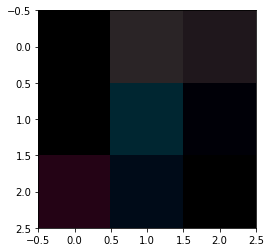

In [0]:
### get the paramter from the begining
net = ConvNet()
b = net.parameters()

params_begin = []
for i,v in enumerate(b):
  if(i == 0):
    params_begin = v


params_begin = params_begin.detach().numpy()
params_norm_begin = params_begin.astype('float') / params_begin.sum(axis=1)[:, np.newaxis]

plt.imshow(params_begin[15],cmap="gray")

In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_func = torch.nn.CrossEntropyLoss() 

In [0]:
a = []
for epoch in range(2):
  b = 1
  a.append(b)




In [0]:
params = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i %  200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    b = net.parameters()
    params.append(list(b)[0])
            
        # print statistics

print('Finished Training')

[1,   200] loss: 2.152
[1,   400] loss: 1.954
[1,   600] loss: 1.917
[1,   800] loss: 1.876
[1,  1000] loss: 1.924
[1,  1200] loss: 1.822
[1,  1400] loss: 1.830
[2,   200] loss: 1.550
[2,   400] loss: 1.527
[2,   600] loss: 1.510
[2,   800] loss: 1.580
[2,  1000] loss: 1.530
[2,  1200] loss: 1.519
[2,  1400] loss: 1.444
Finished Training


In [0]:
PATH = './imageNet_state_4.pkl'
torch.save(net.state_dict(), PATH)


In [0]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()
labels

tensor([6, 3, 8, 6])

In [0]:
net = ConvNet()
net.load_state_dict(torch.load('./imageNet_state_4.pkl'))

<All keys matched successfully>

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 46 %


In [0]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()


In [0]:
correct = 0
total = 0
con_output = []
con_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        for i in range(4):
          con_labels.append(int(labels[i].numpy()))
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(4):
          con_output.append(int(predicted[i].numpy()))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total)) 

Accuracy of the network on the test images: 50 %


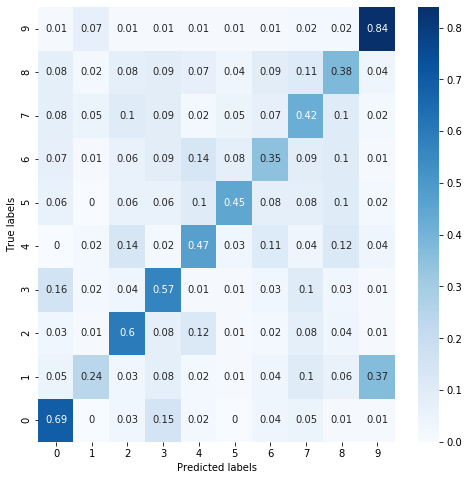

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
con_mat = confusion_matrix(con_labels,con_output)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # normalization
con_mat_norm = np.around(con_mat_norm, decimals=2)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
plt.ylim(0, 10)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [0]:
### get the paramter from the end
net = ConvNet()
b = net.parameters()

params_end = []
for i,v in enumerate(b):
  if(i == 0):
    params_end = v


params_end = params_end.detach().numpy()
params_norm_end = params_end.astype('float') / params_end.sum(axis=1)[:, np.newaxis]


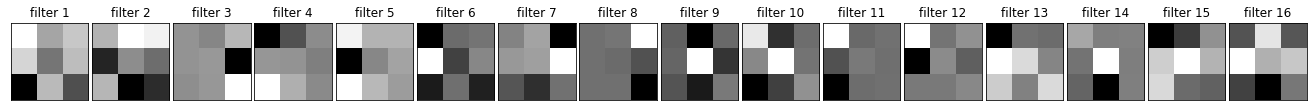

In [0]:


fig = plt.figure(figsize = (12,6))
fig.subplots_adjust(left=0,right=1.5,bottom=0.8,top=1,hspace=0.05,wspace=0.05)
for i in range(16):
  ax = fig.add_subplot(1,16,i+1,xticks=[],yticks=[])
  ax.imshow(params_norm_end[i,:,:,0],cmap ='gray')
  ax.set_title('filter %s'% str(i+1))



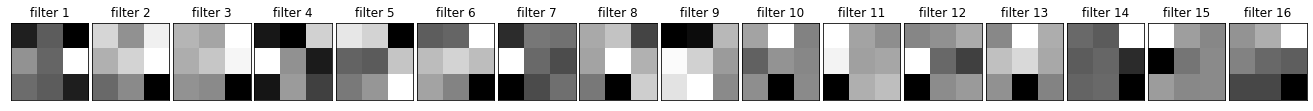

In [0]:
fig = plt.figure(figsize = (12,6))
fig.subplots_adjust(left=0,right=1.5,bottom=0.8,top=1,hspace=0.05,wspace=0.05)
for i in range(16):
  ax = fig.add_subplot(1,16,i+1,xticks=[],yticks=[])
  ax.imshow(params_norm_begin[i,:,:,0],cmap ='gray')
  ax.set_title('filter %s'% str(i+1))

In [0]:
paramsA = params[0].detach().numpy()

params_norm = paramsA.astype('float') / paramsA.sum(axis=1)[:, np.newaxis]

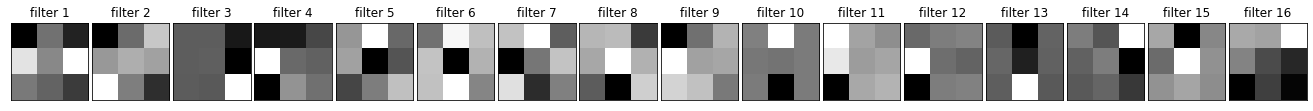

In [0]:
fig = plt.figure(figsize = (12,6))
fig.subplots_adjust(left=0,right=1.5,bottom=0.8,top=1,hspace=0.05,wspace=0.05)
for i in range(16):
  ax = fig.add_subplot(1,16,i+1,xticks=[],yticks=[])
  ax.imshow(params_norm[i,:,:,0],cmap ='gray')
  ax.set_title('filter %s'% str(i+1))

In [0]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
labels

tensor([7, 5, 2, 6])

In [0]:
def rawShow(img):
  img = img/2+0.5
  img = img.numpy()

  plt.imshow(np.transpose(img,(1,2,0))[:,:,:])
  

In [0]:
def imagesShow(img):
  img = img/2+0.5
  img = img.numpy()

  plt.subplot(2,2,1)
  plt.imshow(np.transpose(img,(1,2,0))[:,:,0],cmap = 'gray')
  plt.subplot(2,2,2)
  plt.imshow(np.transpose(img,(1,2,0))[:,:,1],cmap = 'gray')
  plt.subplot(2,2,3)
  plt.imshow(np.transpose(img,(1,2,0))[:,:,2],cmap = 'gray')
  plt.subplot(2,2,4)
  plt.imshow(np.transpose(img,(1,2,0))[:,:,3],cmap = 'gray')  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


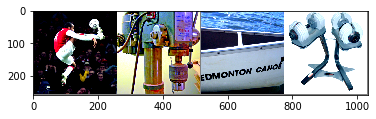

In [0]:
rawShow(torchvision.utils.make_grid(images))

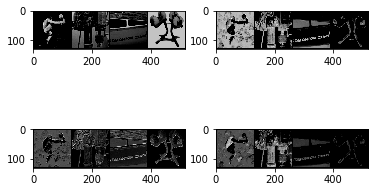

In [0]:
device = 'cuda:0'
net = ConvNet().to(device)
images = images.to(device)
params = list(net.parameters())
first = net.conv1(images)
imagesShow(torchvision.utils.make_grid(first.cpu().detach().clone()))

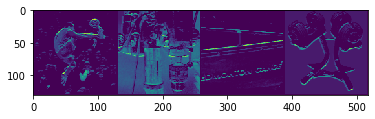

In [0]:
a = torchvision.utils.make_grid(first.cpu().detach().clone())
b = np.transpose(a,(1,2,0))[:,:,4]
plt.imshow(b)

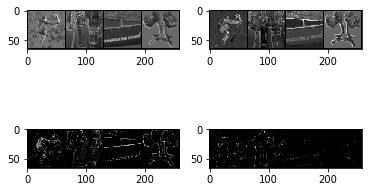

In [0]:
second = net.conv2(first)
imagesShow(torchvision.utils.make_grid(second.cpu().detach().clone()))